# Loading Data

In [53]:
from numbers import Number
from collections import defaultdict

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer
from sina.model import Record, generate_record_from_json
import math
import statistics

%matplotlib notebook

# Initialization
database = './data/num_res_output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")


Sina is ready!


# Adding Data to Records

In [54]:
def RMSE(x_true, x_pred):
    summation = 0
    for xt, xp in zip(x_true,x_pred):
        summation += (xt-xp)**2
    mean = summation/len(x_true)
    rmse = math.sqrt(mean)
    return rmse

def diff(x_true, x_pred):
    dif = []
    for xt, xp in zip(x_true,x_pred):
        dif.append(xt-xp)
    return dif
        
###################################################
# Finding common timesteps using largest timestep #  
###################################################

val_largest_time_step = recs.get('47bcda_3_15')
time_largest_time_step = val_largest_time_step.data['time']['value']

val_nominal_time_step = recs.get('47bcda_3_20')
time_nominal_time_step = val_nominal_time_step.data['time']['value']

val_smallest_time_step = recs.get('47bcda_3_25')
time_smallest_time_step = val_smallest_time_step.data['time']['value']

time_in_all = list(set.intersection(*map(set, [time_largest_time_step, time_nominal_time_step, time_smallest_time_step])))

for rec in recs.get_all():
    
    x_pred = rec.data['x_pos']['value']
    y_pred = rec.data['y_pos']['value']
    z_pred = rec.data['z_pos']['value']
    time = rec.data['time']['value']
    
    x_pred_common = []
    y_pred_common = []
    z_pred_common = []
    time_common = []
    
    for i, t in enumerate(time):
        for t2 in time_in_all:
            if t == t2:
                x_pred_common.append(x_pred[i])
                y_pred_common.append(y_pred[i])
                z_pred_common.append(z_pred[i])
                time_common.append(time[i])
                

    rec.add_data('time_common',time_common)
    rec.add_data('x_common',x_pred_common)
    rec.add_data('y_common',y_pred_common)
    rec.add_data('z_common',z_pred_common)

    recs.update(rec) # need to update or else won't save!!!!!
      
        
###############################################################
# Comparing to TICKS_PER_SECOND = 20 with new common timestep #  
###############################################################

val = recs.get('47bcda_3_20')
print(val.data.keys()) # since there are no embedded keys we can just use this
#print(val.curve_sets) # no curve sets

x_true = val.data['x_common']['value']
y_true = val.data['y_common']['value']
z_true = val.data['z_common']['value']
time_true = val.data['time_common']['value']

for rec in recs.get_all():
    
    x_pred = rec.data['x_common']['value']
    y_pred = rec.data['y_common']['value']
    z_pred = rec.data['z_common']['value']
    
    x_diff = diff(x_true, x_pred)
    x_rmse = RMSE(x_true, x_pred)
    y_diff = diff(y_true, y_pred)
    y_rmse = RMSE(y_true, y_pred)
    z_diff = diff(z_true, z_pred)
    z_rmse = RMSE(z_true, z_pred)
    
    print(x_rmse)
    print(y_rmse)
    print(z_rmse)
    
    rec.add_data('x_rmse',x_rmse)
    rec.add_data('x_diff',x_diff)
    rec.add_data('y_rmse',y_rmse)
    rec.add_data('y_diff',y_diff)
    rec.add_data('z_rmse',z_rmse)
    rec.add_data('z_diff',z_diff)
    
    recs.update(rec) # need to update or else won't save!!!!!

########################################################
# Mean and Standard Deviation with new common timestep #  
########################################################

mean_rec = Record(id= "mean", type="summary")
# recs.delete("mean")

x_temp = []
y_temp = []
z_temp = []

x_mean = []
y_mean = []
z_mean = []
x_std = []
y_std = []
z_std = []

for i , t in enumerate(time_common):
    
    for rec in recs.get_all():

        x_pred = rec.data['x_common']['value'][i]
        y_pred = rec.data['y_common']['value'][i]
        z_pred = rec.data['z_common']['value'][i]

        x_temp.append(x_pred)
        y_temp.append(y_pred)
        z_temp.append(z_pred)
        
          
        
    x_mean.append(statistics.mean(x_temp))
    y_mean.append(statistics.mean(y_temp))
    z_mean.append(statistics.mean(z_temp))
    x_std.append(statistics.stdev(x_temp))
    y_std.append(statistics.stdev(y_temp))
    z_std.append(statistics.stdev(z_temp))
    
    x_temp = []
    y_temp = []
    z_temp = []

mean_rec.add_data('time_common',time_common)
mean_rec.add_data('x_pos_mean',x_mean)
mean_rec.add_data('y_pos_mean',y_mean)
mean_rec.add_data('z_pos_mean',z_mean)
mean_rec.add_data('x_pos_std',x_std)
mean_rec.add_data('y_pos_std',y_std)
mean_rec.add_data('z_pos_std',z_std)    

mean_rec.add_data('x_pos_mean_plus_std', [ x_mean[i] + x_std[i] for i in range (len (time_common))])
mean_rec.add_data('y_pos_mean_plus_std', [ y_mean[i] + y_std[i] for i in range (len (time_common))])
mean_rec.add_data('z_pos_mean_plus_std', [ z_mean[i] + z_std[i] for i in range (len (time_common))])
mean_rec.add_data('x_pos_mean_minus_std', [ x_mean[i] - x_std[i] for i in range (len (time_common))])
mean_rec.add_data('y_pos_mean_minus_std', [ y_mean[i] - y_std[i] for i in range (len (time_common))])
mean_rec.add_data('z_pos_mean_minus_std', [ z_mean[i] - z_std[i] for i in range (len (time_common))])

mean_rec.add_data('x_pos_mean_plus_2std', [ x_mean[i] + 2*x_std[i] for i in range (len (time_common))])
mean_rec.add_data('y_pos_mean_plus_2std', [ y_mean[i] + 2*y_std[i] for i in range (len (time_common))])
mean_rec.add_data('z_pos_mean_plus_2std', [ z_mean[i] + 2*z_std[i] for i in range (len (time_common))])
mean_rec.add_data('x_pos_mean_minus_2std', [ x_mean[i] - 2*x_std[i] for i in range (len (time_common))])
mean_rec.add_data('y_pos_mean_minus_2std', [ y_mean[i] - 2*y_std[i] for i in range (len (time_common))])
mean_rec.add_data('z_pos_mean_minus_2std', [ z_mean[i] - 2*z_std[i] for i in range (len (time_common))])

recs.insert(mean_rec) # need to update or else won't save!!!!!    

100 100
100 100
100 100
dict_keys(['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'gravity', 'box_side_length', 'group_id', 'time', 'x_pos', 'y_pos', 'z_pos', 'x_vel_final', 'y_vel_final', 'z_vel_final', 'num_bounces', 'time_common', 'x_common', 'y_common', 'z_common'])
1.3686162651325302
2.206586527700017
1.3220379586317468
0.0
0.0
0.0
1.0068790426142677
1.5480171946723738
0.8511026043892631


# Parameter Table

In [55]:
header = 1

id_pool = list(recs.get_all(ids_only=True))
id_pool.remove('mean')
id_pool = id_pool[::-1]
print(id_pool)

for rec_id in id_pool:
    
    rec = recs.get(rec_id)
    
    if header == 1:
        print('| rec.id | x_pos_initial | y_pos_initial | z_pos_initial | x_vel_initial | y_vel_initial | z_vel_initial |')
        print('| --- | --- | --- | --- | --- | --- | --- |')
        header = 0
    print('|',rec.id,
      '|',rec.data['x_pos_initial']['value'],
      '|',rec.data['y_pos_initial']['value'],
      '|',rec.data['z_pos_initial']['value'],
      '|',rec.data['x_vel_initial']['value'],
      '|',rec.data['y_vel_initial']['value'],
      '|',rec.data['z_vel_initial']['value'],
      '|'
      )

['47bcda_3_25', '47bcda_3_20', '47bcda_3_15']
| rec.id | x_pos_initial | y_pos_initial | z_pos_initial | x_vel_initial | y_vel_initial | z_vel_initial |
| --- | --- | --- | --- | --- | --- | --- |
| 47bcda_3_25 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |
| 47bcda_3_20 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |
| 47bcda_3_15 | 49.0 | 50.0 | 51.0 | 5.25 | 4.9 | 5.0 |


# Plotting QoIs and their Diff

<IPython.core.display.Javascript object>


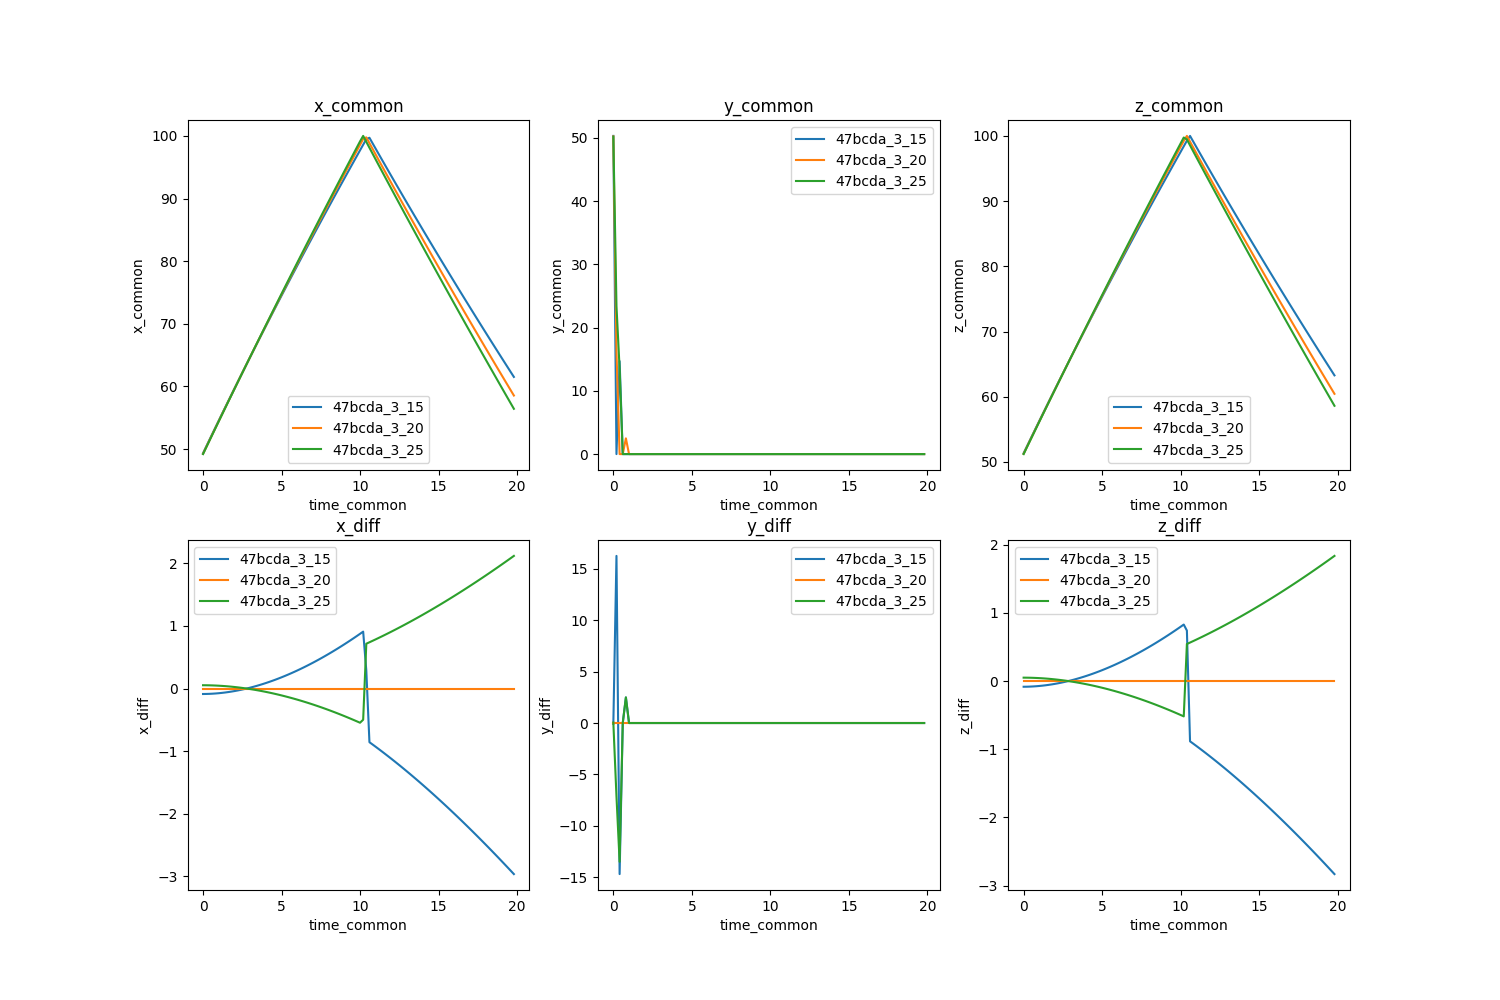

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))


_ = vis.create_line_plot(fig=fig, ax=ax[0,0],x="time_common", y="x_common", title = "{y_name}", id_pool=id_pool)
_ = vis.create_line_plot(fig=fig, ax=ax[0,1],x="time_common", y="y_common", title = "{y_name}", id_pool=id_pool)
_ = vis.create_line_plot(fig=fig, ax=ax[0,2],x="time_common", y="z_common", title = "{y_name}", id_pool=id_pool)

_ = vis.create_line_plot(fig=fig, ax=ax[1,0],x="time_common", y="x_diff", title = "{y_name}", id_pool=id_pool)
_ = vis.create_line_plot(fig=fig, ax=ax[1,1],x="time_common", y="y_diff", title = "{y_name}", id_pool=id_pool)
_ = vis.create_line_plot(fig=fig, ax=ax[1,2],x="time_common", y="z_diff", title = "{y_name}", id_pool=id_pool)

fig.savefig("./images/QoIs_num_res.png")

<IPython.core.display.Javascript object>


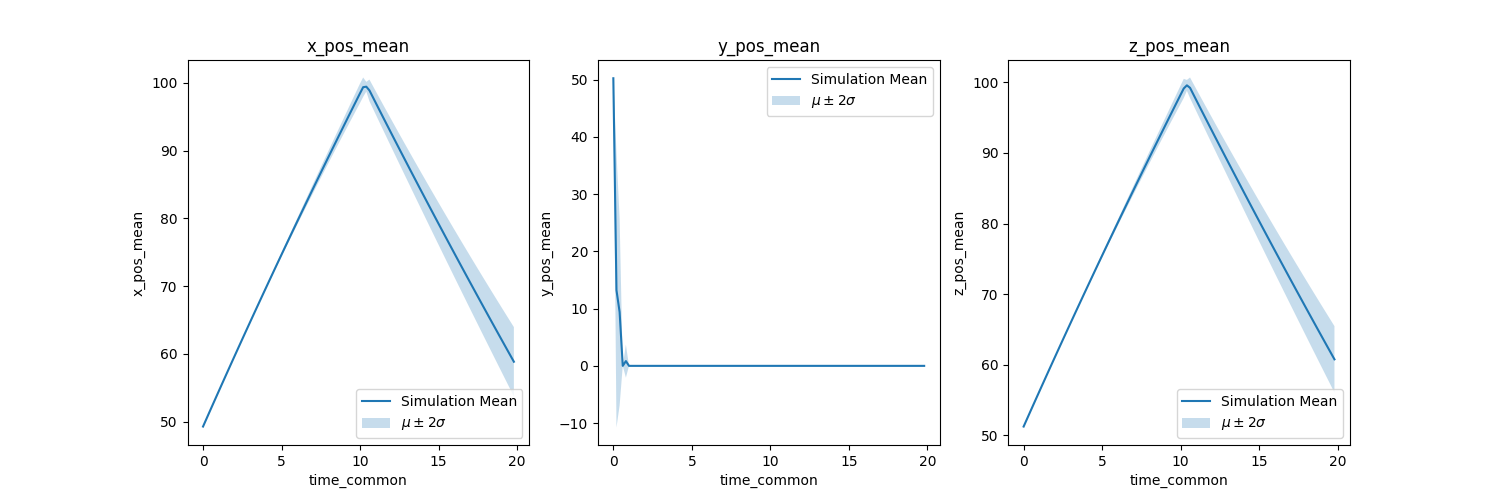

In [58]:
mean = recs.get('mean')
time = mean.data['time_common']['value']
x_pos_mean_plus_2std = mean.data['x_pos_mean_plus_2std']['value']
y_pos_mean_plus_2std = mean.data['y_pos_mean_plus_2std']['value']
z_pos_mean_plus_2std = mean.data['z_pos_mean_plus_2std']['value']

x_pos_mean_minus_2std = mean.data['x_pos_mean_minus_2std']['value']
y_pos_mean_minus_2std = mean.data['y_pos_mean_minus_2std']['value']
z_pos_mean_minus_2std = mean.data['z_pos_mean_minus_2std']['value']


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))



_ = vis.create_line_plot(fig=fig, ax=ax[0],x="time_common", y="x_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[1],x="time_common", y="y_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[2],x="time_common", y="z_pos_mean", title = "{y_name}", id_pool=['mean'])



ax[0].fill_between(time,x_pos_mean_plus_2std,x_pos_mean_minus_2std, alpha=0.25)
ax[1].fill_between(time,y_pos_mean_plus_2std,y_pos_mean_minus_2std, alpha=0.25)
ax[2].fill_between(time,z_pos_mean_plus_2std,z_pos_mean_minus_2std, alpha=0.25)


ax[0].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$'])
ax[1].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$'])
ax[2].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$'])
fig.savefig("./images/QoIs_u_num.png")